In [1]:
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
# The GPU id to use, usually either "0" or "1"
os.environ["CUDA_VISIBLE_DEVICES"]="2"

import tensorflow as tf
from keras import backend as K
print(tf.__version__)
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


1.10.0
['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
import os
import tensorflow as tf
from tensorflow import keras
import numpy as np
import urllib.request
import pandas as pd
from gensim.test.utils import common_texts, get_tmpfile
from gensim.utils import simple_preprocess
from gensim.models import Word2Vec
from tempfile import gettempdir
import zipfile
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_recall_fscore_support, accuracy_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter

print(tf.__version__)

1.10.0


In [3]:
from numpy.random import seed
from tensorflow import set_random_seed

RANDOM_SEED = 20190101

def set_random(random_seed):
    seed(random_seed)
    set_random_seed(random_seed)

set_random(RANDOM_SEED)

In [4]:
class ISEARDataset(object):
  FILENAME = "data/isear_databank.csv"
  EMOTION_CLASSES = ["anger", "disgust", "fear", "guilt", "joy", "sadness", "shame"]
  EMOTION_CLASSES_DICT = {"anger": 0, "disgust": 1, "fear": 2, "guilt": 3, "joy": 4, "sadness": 5, "shame": 6}
  RANDOM_STATE = 41
  
  def get_classes(self):
    return self.EMOTION_CLASSES
  
  def get_classes_dict(self):
    return self.EMOTION_CLASSES_DICT
  
  def __load_data_file(self):
    data = pd.read_csv(self.FILENAME)
    data["emotion"] = data["Field1"]
    data["text"] = data["SIT"]
    return data[["text", "emotion"]]

  def load_data(self):
    train_data = None
    test_data = None
    
    data = self.__load_data_file()
    
    train_data, test_data = train_test_split(data, test_size=0.3, random_state=self.RANDOM_STATE, stratify=data["emotion"].values)
    return train_data, test_data

In [5]:
isear_dataset = ISEARDataset()
train_data, test_data = isear_dataset.load_data()
train_data, valid_data = train_test_split(train_data, test_size=0.1, random_state=200, stratify=train_data.emotion)

print("train_data.shape:", train_data.shape)
print("valid_data.shape:", valid_data.shape)
print("test_data.shape:", test_data.shape)

train_data.shape: (4829, 2)
valid_data.shape: (537, 2)
test_data.shape: (2300, 2)


{'anger': 0, 'disgust': 1, 'fear': 2, 'guilt': 3, 'joy': 4, 'sadness': 5, 'shame': 6}
['anger', 'disgust', 'fear', 'guilt', 'joy', 'sadness', 'shame']
7


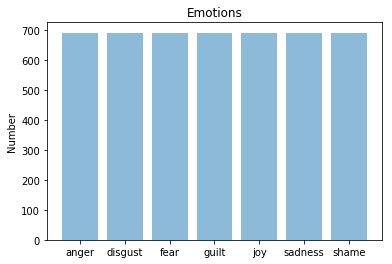

In [6]:
dic = isear_dataset.get_classes_dict()
labels = isear_dataset.get_classes()
print(dic)
print(labels)

for emotion in labels:
  train_data.loc[train_data.emotion == emotion, "emotion_int"] = dic[emotion]
  valid_data.loc[valid_data.emotion == emotion, "emotion_int"] = dic[emotion]
  test_data.loc[test_data.emotion == emotion, "emotion_int"] = dic[emotion]
  
num_bins = len(labels)
print(num_bins)
bins = [0,1,2,3,4,5,6,7]
hist, _ = np.histogram(train_data["emotion_int"], bins=bins)

y_pos = np.arange(len(labels))

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

### Tokenize training and test dataset

In [7]:
NUM_WORDS=20000
texts = train_data.text
tokenizer = Tokenizer(num_words=NUM_WORDS,filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n\'',
                      lower=True)
tokenizer.fit_on_texts(texts)
sequences_train = tokenizer.texts_to_sequences(texts)
sequences_valid = tokenizer.texts_to_sequences(valid_data.text)
sequences_test = tokenizer.texts_to_sequences(test_data.text)
word_index = tokenizer.word_index
print('Found %s unique tokens.' % len(word_index))

Found 7194 unique tokens.


In [8]:
X_train = pad_sequences(sequences_train)
X_val = pad_sequences(sequences_valid, maxlen=X_train.shape[1])
X_test = pad_sequences(sequences_test, maxlen=X_train.shape[1])

y_train = to_categorical(np.asarray(train_data.emotion.apply(lambda x:dic[x])))
y_val = to_categorical(np.asarray(valid_data.emotion.apply(lambda x:dic[x])))
y_test = to_categorical(np.asarray(test_data.emotion.apply(lambda x:dic[x])))

print('Shape of X train, validation and test tensor:', X_train.shape, X_val.shape, X_test.shape)
print('Shape of label train, validation and test tensor:', y_train.shape, y_val.shape, y_test.shape)

Shape of X train, validation and test tensor: (4829, 192) (537, 192) (2300, 192)
Shape of label train, validation and test tensor: (4829, 7) (537, 7) (2300, 7)


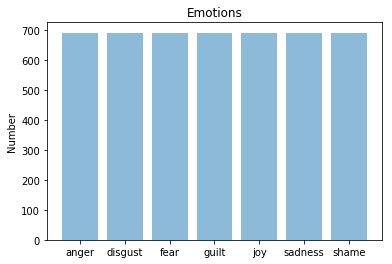

In [9]:
hist, _ = np.histogram(np.argmax(y_train, axis=1), bins=bins)
plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

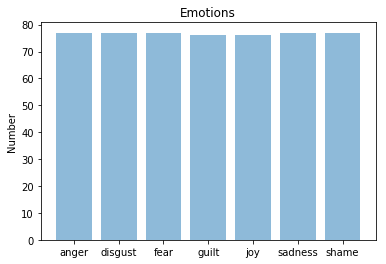

In [10]:
hist, _ = np.histogram(np.argmax(y_val, axis=1), bins=bins)

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

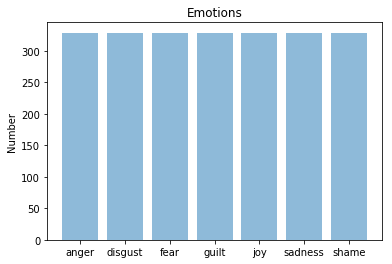

In [11]:
hist, _ = np.histogram(np.argmax(y_test, axis=1), bins=bins)

plt.bar(y_pos, hist, align='center', alpha=0.5)
plt.xticks(y_pos, labels)
plt.ylabel('Number')
plt.title('Emotions')
 
plt.show()

## Word Embedding using Word2Vec trained in Google News

In [13]:
import gensim
from gensim.models import Word2Vec
from gensim.utils import simple_preprocess

from gensim.models.keyedvectors import KeyedVectors

word_vectors = KeyedVectors.load_word2vec_format('../../Datasets/WordEmbeddings/GoogleNews-vectors-negative300.bin.gz', binary=True)

EMBEDDING_DIM=300
vocabulary_size = min(len(word_index)+1, NUM_WORDS)
embedding_matrix = np.zeros((vocabulary_size, EMBEDDING_DIM))
for word, i in word_index.items():
    if i>=NUM_WORDS:
        continue
    try:
        embedding_vector = word_vectors[word]
        embedding_matrix[i] = embedding_vector
    except KeyError:
        embedding_matrix[i] = np.random.normal(0,np.sqrt(0.25), EMBEDDING_DIM)

del(word_vectors)

from keras.layers import Embedding
embedding_layer = Embedding(vocabulary_size,
                            EMBEDDING_DIM,
                            weights=[embedding_matrix],
                            trainable=True)

In [14]:
file_embedded_matrix = "isear_embedded_matrix_word2vec_googlenews.npy"
np.save(file_embedded_matrix, embedding_matrix)

In [15]:
np.save("isear_X_train.npy", X_train)
np.save("isear_X_val.npy", X_val)
np.save("isear_X_test.npy", X_test)

np.save("isear_y_train.npy", y_train)
np.save("isear_y_val.npy", y_val)
np.save("isear_y_test.npy", y_test)

## Reload embedding layer and training dataset

In [16]:
file_embedded_matrix = "isear_embedded_matrix_word2vec_googlenews.npy"
embedding_matrix = np.load(file_embedded_matrix)
print("embedding matrix shape:", embedding_matrix.shape)

embedding matrix shape: (7195, 300)


In [17]:
X_train = np.load("isear_X_train.npy")
X_val = np.load("isear_X_val.npy")
X_test = np.load("isear_X_test.npy")

y_train = np.load("isear_y_train.npy")
y_val = np.load("isear_y_val.npy")
y_test = np.load("isear_y_test.npy")

In [18]:
from keras.layers import Dense, Input, GlobalMaxPooling1D
from keras.layers import Conv1D, MaxPooling1D, Embedding, TimeDistributed
from keras.models import Model
from keras.layers import Input, Dense, Embedding, Conv2D, MaxPooling2D, Dropout, concatenate, LSTM, SpatialDropout1D, Bidirectional
from keras.layers.core import Reshape, Flatten, Lambda
from keras.layers.merge import add
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.optimizers import Adam, Adadelta, RMSprop
from keras.models import Model
from keras import regularizers

In [40]:
sequence_length = X_train.shape[1]
HIDDEN_DIM = 600
DROPOUT_RATE = 0.2
N_CLASSES = 7
EMBEDDING_DIM=300
vocabulary_size = 7195

print("sequence length:", sequence_length)

inputs = Input(shape=(sequence_length,), name='input_1')
embedding_layer = Embedding(vocabulary_size, EMBEDDING_DIM, weights=[embedding_matrix], input_length=sequence_length, trainable=True, name='embedding')
embedding = embedding_layer(inputs)
spatial_droput = SpatialDropout1D(0.4, name='spatial_dropout')(embedding)
lstm = Bidirectional(LSTM(units=HIDDEN_DIM, dropout=DROPOUT_RATE, recurrent_dropout=DROPOUT_RATE, name='lstm'))(spatial_droput)
output = Dense(units=N_CLASSES, activation='softmax', name='output')(lstm)

model = None 

# this creates a model that includes
model = Model(inputs, output)

model.summary()

sequence length: 192
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 192)               0         
_________________________________________________________________
embedding (Embedding)        (None, 192, 300)          2158500   
_________________________________________________________________
spatial_dropout (SpatialDrop (None, 192, 300)          0         
_________________________________________________________________
bidirectional_4 (Bidirection (None, 1200)              4324800   
_________________________________________________________________
output (Dense)               (None, 7)                 8407      
Total params: 6,491,707
Trainable params: 6,491,707
Non-trainable params: 0
_________________________________________________________________


In [41]:
adam = Adam(lr=1e-3, decay=0.0)
adadelta = Adadelta(lr=1.0, rho=0.95, epsilon=None, decay=0.0)
rmsprop = RMSprop(lr=0.001, rho=0.9, epsilon=None, decay=0.0)

model.compile(loss='categorical_crossentropy', optimizer=adam, metrics=['acc'])

filepath="tmp/weights-{epoch:02d}-{val_acc:.2f}.hdf5"
model_checkpoint = ModelCheckpoint(filepath, monitor='val_acc', verbose=1, save_best_only=True, mode='auto')
early_stopping = EarlyStopping(monitor='val_loss', patience=3)
callbacks = [early_stopping, model_checkpoint]

history = model.fit(X_train, y_train, batch_size=100, epochs=100, verbose=1, validation_data=(X_val, y_val), callbacks=callbacks)  # starts training

Train on 4829 samples, validate on 537 samples
Epoch 1/100
4829/4829 [==============================] - 44s 9ms/step - loss: 1.8549 - acc: 0.2591 - val_loss: 1.7310 - val_acc: 0.3575

Epoch 00001: val_acc improved from -inf to 0.35754, saving model to tmp/weights-01-0.36.hdf5
Epoch 2/100
4829/4829 [==============================] - 40s 8ms/step - loss: 1.6064 - acc: 0.3955 - val_loss: 1.4819 - val_acc: 0.4469

Epoch 00002: val_acc improved from 0.35754 to 0.44693, saving model to tmp/weights-02-0.45.hdf5
Epoch 3/100
4829/4829 [==============================] - 39s 8ms/step - loss: 1.4133 - acc: 0.4734 - val_loss: 1.3816 - val_acc: 0.5009

Epoch 00003: val_acc improved from 0.44693 to 0.50093, saving model to tmp/weights-03-0.50.hdf5
Epoch 4/100
4829/4829 [==============================] - 39s 8ms/step - loss: 1.1907 - acc: 0.5662 - val_loss: 1.2705 - val_acc: 0.5140

Epoch 00004: val_acc improved from 0.50093 to 0.51397, saving model to tmp/weights-04-0.51.hdf5
Epoch 5/100
4829/4829 [=

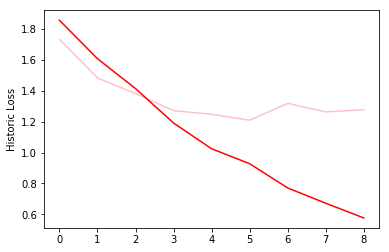

In [42]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_loss'], color='pink')
plt.plot(history.history['loss'], color='red')
plt.ylabel('Historic Loss')
plt.show()

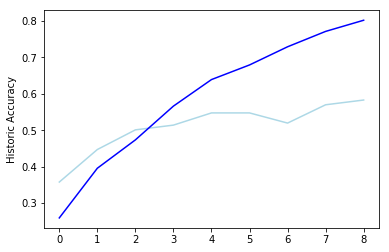

In [43]:
import matplotlib.pyplot as plt
plt.plot(history.history['val_acc'], color='lightblue')
plt.plot(history.history['acc'], color='blue')
plt.ylabel('Historic Accuracy')
plt.show()

In [44]:
model_path = 'isear_bidirectional_lstm_word2vec_googlenews_model.h5'
weight_path = 'isear_bidirectional_lstm_word2vec_googlenews_weights.h5'

model.save(model_path)
model.save_weights(weight_path)

In [45]:
sequences_test=tokenizer.texts_to_sequences(test_data.text)
X_test = pad_sequences(sequences_test, maxlen=X_test.shape[1])
y_pred = model.predict(X_test)

y_pred_original = [labels[val] for val in np.argmax(y_pred, axis=1).squeeze()]
y_test_original = np.asarray(test_data.emotion)

In [46]:
def print_confusion_matrix(confusion_matrix, class_names, figsize = (4,3), fontsize=15):
    """Prints a confusion matrix, as returned by sklearn.metrics.confusion_matrix, as a heatmap.
    
    Arguments
    ---------
    confusion_matrix: numpy.ndarray
        The numpy.ndarray object returned from a call to sklearn.metrics.confusion_matrix. 
        Similarly constructed ndarrays can also be used.
    class_names: list
        An ordered list of class names, in the order they index the given confusion matrix.
    figsize: tuple
        A 2-long tuple, the first value determining the horizontal size of the ouputted figure,
        the second determining the vertical size. Defaults to (10,7).
    fontsize: int
        Font size for axes labels. Defaults to 14.
        
    Returns
    -------
    matplotlib.figure.Figure
        The resulting confusion matrix figure
    """
    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names, 
    )
    fig = plt.figure(figsize=figsize)
    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d")
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    return fig

In [47]:
cf_matrix = confusion_matrix(y_test_original, y_pred_original, labels=labels)

df_cm = pd.DataFrame(
    cf_matrix, index=labels, columns=labels, 
)

df_cm

,anger,disgust,fear,guilt,joy,sadness,shame
anger,189,30,15,46,20,16,13
disgust,47,208,22,13,16,7,16
fear,16,11,233,22,17,21,8
guilt,78,15,19,161,14,18,23
joy,11,12,14,8,238,33,12
sadness,40,12,21,21,27,193,15
shame,53,30,22,66,22,13,123


Figure(288x216)


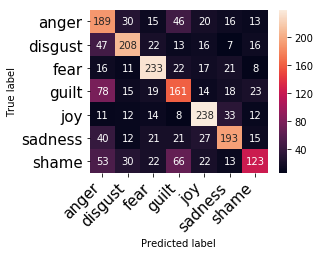

In [48]:
print(print_confusion_matrix(cf_matrix, class_names=labels))

In [49]:
test_accuracy = accuracy_score(y_test_original, y_pred_original)
print("test accuracy:", test_accuracy)

test accuracy: 0.5847826086956521


### Performance score for each classes

In [50]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original)
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support.round(4)
}
score_df = pd.DataFrame(score_dict, index=labels)
score_df

,precision,recall,f1-score,support
anger,0.4355,0.5745,0.4954,329
disgust,0.6541,0.6322,0.6430,329
fear,0.6734,0.7104,0.6914,328
guilt,0.4777,0.4909,0.4842,328
joy,0.6723,0.7256,0.6979,328
sadness,0.6412,0.5866,0.6127,329
shame,0.5857,0.3739,0.4564,329


### Performance score using micro average

In [51]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="micro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.5848,0.5848,0.5848,None


### Performance score using macro average

In [52]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="macro")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.5914,0.5849,0.583,None


### Performance score using weighted average

In [53]:
precision, recall, fscore, support = precision_recall_fscore_support(y_test_original, y_pred_original, average="weighted")
score_dict = {
  "precision": precision.round(4),
  "recall": recall.round(4),
  "f1-score": fscore.round(4),
  "support": support
}
score_df = pd.DataFrame(score_dict, index=["score"])
score_df

,precision,recall,f1-score,support
score,0.5914,0.5848,0.583,None


### Cohen Kappa Score

In [54]:
from sklearn.metrics import cohen_kappa_score

kappa_score = cohen_kappa_score(y_test_original, y_pred_original, labels=labels)
print("kappa:", kappa_score)

kappa: 0.5155851891908343
